In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# LEGA-C Mock Demo

This notebook demonstrates how to make a mock for the LEGA-C survey. 

## download and load halo catalog

First, you need to make sure you have downloaded the relavent halo catalog.  In this case, we will use the Bolshoi Planck simulation.  This function downloads (if you havent already done so) the z=1 ROCKSTAR halo catalog.  This catalog has been slightly processed for halotools.

In [2]:
# downlaod halo catalog if you don't have it
from halotools.sim_manager import DownloadManager
dman = DownloadManager()

from halotools.custom_exceptions import HalotoolsError
try:
    dman.download_processed_halo_table('bolplanck', 'rockstar', 1.0) 
except HalotoolsError:
    pass  # you already have this downloaded.

/Users/duncan/Code/halotools/halotools/sim_manager/download_manager.py:933: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 933 of the file /Users/duncan/Code/halotools/halotools/sim_manager/download_manager.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(requests.get(baseurl).text)
/Users/duncan/Code/halotools/halotools/sim_manager/download_manager.py:942: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and b

Now you need to load the halo catalog into memory.

In [3]:
# load halo catalog
from halotools import sim_manager
simname = 'bolplanck'
halocat = sim_manager.CachedHaloCatalog(simname = simname, redshift=1.0, dz_tol = 0.01,
                                        version_name='halotools_v0p4', halo_finder='rockstar')

In [4]:
# print out the column names of catalog
for key in halocat.halo_table.keys():
    print(key)

print("")
print("number of (sub-)haloes in catalog: {0}".format(len(halocat.halo_table)))
print("length of simulation box side: {0} Mpc/h".format(halocat.Lbox[0]))

halo_vmax_firstacc
halo_dmvir_dt_tdyn
halo_macc
halo_scale_factor
halo_vmax_mpeak
halo_m_pe_behroozi
halo_delta_vmax_behroozi17
halo_xoff
halo_spin
halo_tidal_force
halo_scale_factor_firstacc
halo_c_to_a
halo_mvir_firstacc
halo_scale_factor_last_mm
halo_tidal_id
halo_scale_factor_mpeak
halo_pid
halo_m500c
halo_id
halo_halfmass_scale_factor
halo_upid
halo_t_by_u
halo_rvir
halo_vpeak
halo_dmvir_dt_100myr
halo_mpeak
halo_m_pe_diemer
halo_jx
halo_jy
halo_jz
halo_m2500c
halo_mvir
halo_voff
halo_axisA_z
halo_axisA_x
halo_axisA_y
halo_y
halo_b_to_a
halo_x
halo_z
halo_m200b
halo_vacc
halo_scale_factor_lastacc
halo_vmax
halo_m200c
halo_vx
halo_vy
halo_vz
halo_dmvir_dt_inst
halo_tidal_force_tdyn
halo_rs
halo_nfw_conc
halo_hostid
halo_mvir_host_halo

number of haloes in catalog: 1470957
length of simulation box side: 250.0 Mpc/h


## define galaxy-halo connection

Now we need to define the model we will use to associate galaxies and (sub-)haloes.  This could be one of the pre-defined models included within Halotools, but we will use a custom model.  

In [7]:
# SMHM model
from halotools.empirical_models import PrebuiltSubhaloModelFactory
model = PrebuiltSubhaloModelFactory('behroozi10', redshift = 1.0)

In [23]:
# SHAM model
from legac_mocks.sham_model import DeconvolveSHAM
from legac_mocks.galaxy_abundance_functions import Tomczak_2014_phi, Davidzon_2017_phi
from halotools.empirical_models import SubhaloModelFactory

# define galaxy stellar mass function for mock
phi = Davidzon_2017_phi(redshift=1.0, type='all')


sm_model =  DeconvolveSHAM(stellar_mass_function = phi, scatter=0.15, redshift=1.0,
                           prim_galprop='stellar_mass', prim_haloprop='halo_vpeak', Lbox=halocat.Lbox)
model_1a = SubhaloModelFactory(stellar_mass = sm_model)

In [24]:
# populate mock
model_1a.populate_mock(halocat)  

Error automatically detecting Lbox.


In [25]:
mock = model_1a.mock.galaxy_table
for key in mock.keys():
    print(key)

halo_upid
halo_hostid
halo_x
halo_y
halo_id
halo_z
halo_vx
halo_vy
halo_vz
halo_rvir
halo_vpeak
halo_mvir
halo_mvir_host_halo
x
y
z
vx
vy
vz
galid
stellar_mass


## stellar mass function

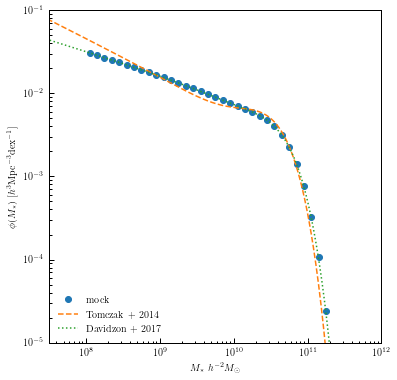

In [26]:
# stellar mass function
from legac_mocks.galaxy_abundance_functions import Tomczak_2014_phi, Davidzon_2017_phi

# stellar mass function
msample = np.logspace(7,12,1000)
phi_1 = Tomczak_2014_phi()
phi_2 = Davidzon_2017_phi(redshift=1.0)

bins = np.arange(8,12,0.1)
bins = 10.0**bins
bin_centers = (bins[:-1]+bins[1:])/2.0

counts = np.histogram(mock['stellar_mass'], bins=bins)[0]
counts = counts/np.prod(halocat.Lbox)/0.1


fig = plt.figure(figsize=(6.6,6.6))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
p1, = plt.plot(bin_centers, counts, 'o')
l1, = plt.plot(msample, phi_1(msample), '--')
l2, = plt.plot(msample, phi_2(msample), ':')
plt.yscale('log')
plt.xscale('log')
plt.ylim([10**-5,0.1])
plt.xlim([10**7.5,10**12])
plt.legend([p1,l1, l2],['mock','Tomczak + 2014', 'Davidzon + 2017'], loc='lower left', frameon=False, fontsize=10)
plt.xlabel(r'$M_{*}~h^{-2}M_{\odot}$')
plt.ylabel(r'$\phi(M_*)~[h^{3}{\rm Mpc}^{-3}{\rm dex}^{-1}]$')
plt.show()


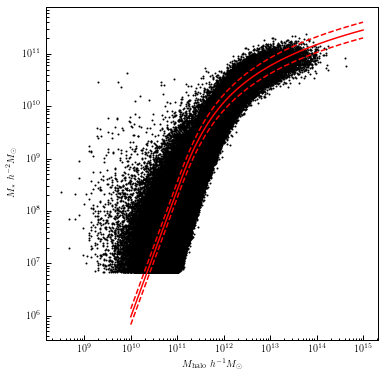

In [33]:
m_sample = np.logspace(10,15,100)

centrals = (mock['halo_upid']==-1)

fig = plt.figure(figsize=(6.6,6.6))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.scatter(mock['halo_mvir'][centrals], mock['stellar_mass'][centrals],s=1, color='black')
plt.plot(m_sample, model.mean_stellar_mass(prim_haloprop=m_sample), color='red')
down_scatter = 10**(np.log10(model.mean_stellar_mass(prim_haloprop=m_sample)) - 0.15)
up_scatter = 10**(np.log10(model.mean_stellar_mass(prim_haloprop=m_sample)) + 0.15)
plt.plot(m_sample, down_scatter, '--', color='red')
plt.plot(m_sample, up_scatter, '--', color='red')
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$M_{*}~h^{-2}M_{\odot}$')
plt.xlabel(r'$M_{\rm halo}~h^{-1}M_{\odot}$')
plt.show()

## galaxy clustering

In [43]:
from halotools.mock_observables import tpcf, wp

In [45]:
coords = np.vstack((mock['halo_x'], mock['halo_y'], mock['halo_z'])).T

rp_bins = np.logspace(-1,1,20)
rpbin_centers = (rbins[:-1]+rbins[1:])/2.0

mask = mock['stellar_mass']>10**9.5
xi_1 = wp(coords[mask], rp_bins, pi_max=40, period=halocat.Lbox)

mask = mock['stellar_mass']>10**10
xi_2 = wp(coords[mask], rp_bins, pi_max=40, period=halocat.Lbox)

mask = mock['stellar_mass']>10**10.5
xi_3 = wp(coords[mask], rp_bins, pi_max=40, period=halocat.Lbox)

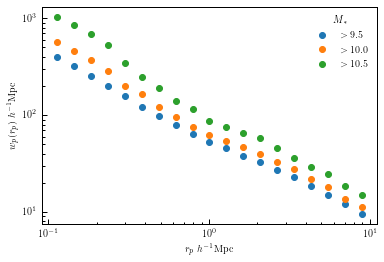

In [53]:
plt.figure()
p1, = plt.plot(rbin_centers, xi_1, 'o')
p2, = plt.plot(rbin_centers, xi_2, 'o')
p3, = plt.plot(rbin_centers, xi_3, 'o')
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$w_p(r_p)~h^{-1}{\rm Mpc}$')
plt.xlabel(r'$r_p~h^{-1}{\rm Mpc}$')
plt.legend([p1, p2, p3], [r'$>9.5$',r'$>10.0$',r'$>10.5$'], title=r'$M_*$',
           loc='upper right', frameon=False, fontsize=10)
plt.show()